In [2]:
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import pymap3d as pm
import numpy as np


gps_topic = "/gps/fix"
imu_topic = "/imu/imu_uncompensated"

np.set_printoptions(precision=6, suppress=True, linewidth=110)


In [3]:
b = bagreader('2023-10-19-14-14-38-filtered.bag')
print(b.topic_table)

[INFO]  Data folder 2023-10-19-14-14-38-filtered already exists. Not creating.
                            Topics                             Types  \
0                         /gps/fix             sensor_msgs/NavSatFix   
1              /gps/time_reference         sensor_msgs/TimeReference   
2             /imu/imu_compensated                   sensor_msgs/Imu   
3           /imu/imu_uncompensated                   sensor_msgs/Imu   
4       /vehicle/brake_info_report      dbw_mkz_msgs/BrakeInfoReport   
5            /vehicle/brake_report          dbw_mkz_msgs/BrakeReport   
6             /vehicle/dbw_enabled                     std_msgs/Bool   
7       /vehicle/fuel_level_report      dbw_mkz_msgs/FuelLevelReport   
8             /vehicle/gear_report           dbw_mkz_msgs/GearReport   
9                 /vehicle/gps/fix             sensor_msgs/NavSatFix   
10               /vehicle/gps/time         sensor_msgs/TimeReference   
11                /vehicle/gps/vel        geometry_msgs/T

Index(['Time', 'header.seq', 'header.stamp.secs', 'header.stamp.nsecs',
       'header.frame_id', 'status.status', 'status.service', 'latitude',
       'longitude', 'altitude', 'position_covariance_0',
       'position_covariance_1', 'position_covariance_2',
       'position_covariance_3', 'position_covariance_4',
       'position_covariance_5', 'position_covariance_6',
       'position_covariance_7', 'position_covariance_8',
       'position_covariance_type'],
      dtype='object')


(-71.09485995, -71.05556171666667, 42.33765005, 42.36832795)

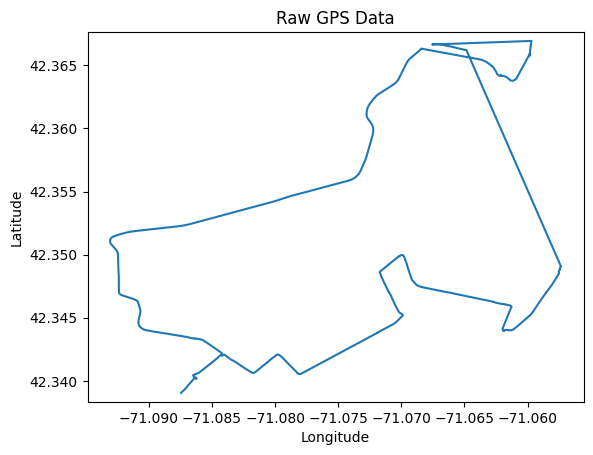

In [4]:
gps_data = b.message_by_topic(gps_topic)
df_gps = pd.read_csv(gps_data)
df_gps = df_gps.dropna()
print(df_gps.columns)

df_gps.plot(x='longitude', y='latitude', ylabel='Latitude', xlabel='Longitude', title='Raw GPS Data', legend=False)
plt.axis('equal')
plt.show()

In [5]:
df_lat_long = df_gps[['latitude', 'longitude']]
df_lat_long.to_csv('lat_long.csv')

In [6]:
df_gps['longitude'][0:5].plot()

<AxesSubplot: >

<AxesSubplot: >

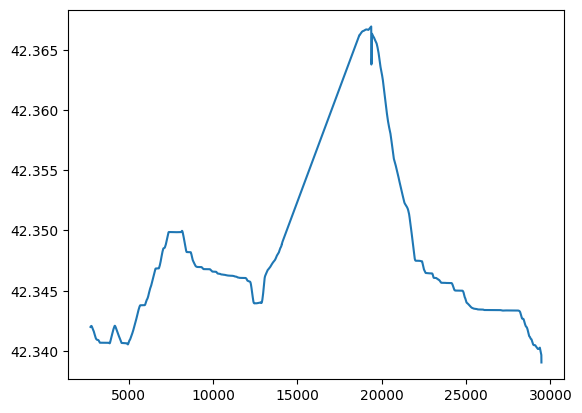

In [7]:
df_gps['latitude'].plot()

In [8]:
# pos_cov 1,2,3,5,6,7 is 0
# pos_cov 0,4,8
# pos_cov 0 and 4 are nearly identical
# pos_cov 8 is around 10 times larger than 0 and 4

# df_gps['position_covariance_0'].plot(legend=True)
# df_gps['position_covariance_4'].plot(legend=True)
# df_gps['position_covariance_8'][3500:6000].plot(legend=True)

df_gps['position_covariance_type'].plot(legend=True) # covariance type is 0 when covariance is unknown assumed to be infinity
# type 1 is actual covariance value

# replace too high covariances to max value of 100
df_gps.loc[df_gps['position_covariance_0'] > 100, 'position_covariance_0'] = 100
df_gps.loc[df_gps['position_covariance_4'] > 100, 'position_covariance_4'] = 100


df_gps['position_covariance_0'].plot(legend=True)
df_gps['position_covariance_4'].plot(legend=True)

<AxesSubplot: >

In [9]:
imu_data = b.message_by_topic(imu_topic)
df_imu = pd.read_csv(imu_data)
df_imu = df_imu.dropna()
print(df_imu.columns)

Index(['Time', 'header.seq', 'header.stamp.secs', 'header.stamp.nsecs',
       'header.frame_id', 'orientation.x', 'orientation.y', 'orientation.z',
       'orientation.w', 'orientation_covariance_0', 'orientation_covariance_1',
       'orientation_covariance_2', 'orientation_covariance_3',
       'orientation_covariance_4', 'orientation_covariance_5',
       'orientation_covariance_6', 'orientation_covariance_7',
       'orientation_covariance_8', 'angular_velocity.x', 'angular_velocity.y',
       'angular_velocity.z', 'angular_velocity_covariance_0',
       'angular_velocity_covariance_1', 'angular_velocity_covariance_2',
       'angular_velocity_covariance_3', 'angular_velocity_covariance_4',
       'angular_velocity_covariance_5', 'angular_velocity_covariance_6',
       'angular_velocity_covariance_7', 'angular_velocity_covariance_8',
       'linear_acceleration.x', 'linear_acceleration.y',
       'linear_acceleration.z', 'linear_acceleration_covariance_0',
       'linear_accelerat

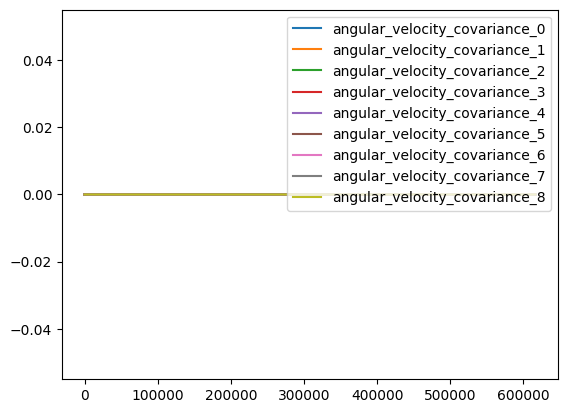

In [10]:
# all imu covariances are 0

for i in range(9):
    df_imu[f'angular_velocity_covariance_{i}'].plot(legend=True)

In [11]:
range_lower = 0
range_upper = 2950 # last message: 616322
df_imu['angular_velocity.x'][range_lower:range_upper].plot(legend=True)
df_imu['angular_velocity.y'][range_lower:range_upper].plot(legend=True)
df_imu['angular_velocity.z'][range_lower:range_upper].plot(legend=True)
df_imu['angular_velocity_covariance_0'][range_lower:range_upper].plot(legend=True)


<AxesSubplot: >

In [12]:
# consider accerleration as system input, position and velocity as state variables

# Establish frequencies 
gps_freq, imu_freq = b.frequency[0], b.frequency[3]

print('GPS frequency:', gps_freq)
print('IMU frequency:', imu_freq)
print('IMU/GPS frequency ratio:', freq_ratio:=imu_freq/gps_freq)

GPS frequency: 10.00910156091531
IMU frequency: 200.1385694517345
IMU/GPS frequency ratio: 19.995657775444958


In [13]:
# IMU initialization
# just need accel_x and accel_y and gyro_z

rest_start = 0
rest_end = 2950

accel_x_mean = df_imu['linear_acceleration.x'][rest_start:rest_end].mean()
accel_x_var = df_imu['linear_acceleration.x'][rest_start:rest_end].var()

accel_y_mean = df_imu['linear_acceleration.y'][rest_start:rest_end].mean()
accel_y_var = df_imu['linear_acceleration.y'][rest_start:rest_end].var()

gyro_z_mean = df_imu['angular_velocity.z'][rest_start:rest_end].mean()
gyro_z_var = df_imu['angular_velocity.z'][rest_start:rest_end].var()

print('Acceleration X bias and variance: ', accel_x_mean, accel_x_var)
print('Acceleration Y bias and variance: ', accel_y_mean, accel_y_var)
print('Gyroscope Z bias and variance: ', gyro_z_mean, gyro_z_var)

non_biased_accel_x = df_imu['linear_acceleration.x'] - accel_x_mean
non_biased_accel_y = df_imu['linear_acceleration.y'] - accel_y_mean
non_biased_gyro_z = df_imu['angular_velocity.z'] - gyro_z_mean

Acceleration X bias and variance:  -0.5244510921179238 0.0005224856611341066
Acceleration Y bias and variance:  0.009413146546082869 0.0009206683231505083
Gyroscope Z bias and variance:  -0.036284924813751396 4.897022362965223e-07


<AxesSubplot: title={'center': 'Raw Acceleration without Bias'}, ylabel='$[m/s^2]$'>

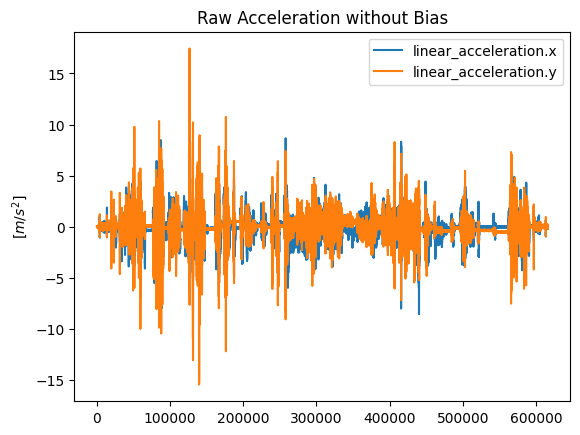

In [14]:
non_biased_accel_x.plot(legend=True)
non_biased_accel_y.plot(legend=True, title='Raw Acceleration without Bias', ylabel='$[m/s^2]$')

In [15]:
non_biased_gyro_z.plot(legend=True, title='Raw Angular Velocity without Bias', ylabel='[rad/s]')

<AxesSubplot: title={'center': 'Raw Angular Velocity without Bias'}, ylabel='[rad/s]'>

In [16]:
# questions:

#UTM or NED or ENU

# gps covariance?
# imu covariance? taken from rest or some other way, covariances vs individual variances?
# how is the imu mounted, which way is +x and +y
# what to use as measurement for angle? we can integrate z angular velocity, but should we use the orientation as well?
# trying to get angle from gps measurements is funky as well
# how is vehicle gps fix able to maintian connection while underground
# measurement noise, should we use covariance between x,y and theta_dot, or an arbitraty number. I've seen numbers as high as 10000, but covariance between them is <1
# what is the point of Q matrix, we know we are getting noisy data, why do we have to add more noise

In [17]:
def gps_to_meters(start_location, lat, lon, alt):
    # returns in east, north, up coordinates
    lat0 = start_location[0]
    lon0 = start_location[1]
    h0 = start_location[2]

    return pm.geodetic2enu(lat, lon, alt, lat0, lon0, h0)

# start of gps data: 2735
start_location = df_gps['latitude'].iloc[0], df_gps['longitude'].iloc[0], df_gps['altitude'].iloc[0]
print(start_location)

print(gps_to_meters(start_location, df_gps['latitude'][2745], df_gps['longitude'][2745], df_gps['altitude'][2745]))

(42.341995833333335, -71.084166, -32.6)
(0.7965837336444697, 3.3138684548459674, 1.5999990863621671)


In [18]:
# visualizing quaternions
from scipy.spatial.transform import Rotation as R

quat_df = df_imu[['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w']]

rot = R.from_quat(quat_df)
print(rot[0].as_mrp())
print(rot[0].as_euler('xyz', degrees=True))
rot_euler = rot.as_euler('xyz', degrees=False)
print(rot_euler[0])


[-0.000103 -0.013672 -0.000204]
[-0.02235  -3.133133 -0.04604 ]
[-0.00039  -0.054683 -0.000804]


In [19]:
def plot_rotated_axes(ax, r, name=None, offset=(0, 0, 0), scale=1):
    colors = ("#FF6666", "#005533", "#1199EE")  # Colorblind-safe RGB
    loc = np.array([offset, offset])
    for i, (axis, c) in enumerate(zip((ax.xaxis, ax.yaxis, ax.zaxis),
                                      colors)):
        axlabel = axis.axis_name
        axis.set_label_text(axlabel)
        axis.label.set_color(c)
        axis.line.set_color(c)
        axis.set_tick_params(colors=c)
        line = np.zeros((2, 3))
        line[1, i] = scale
        line_rot = r.apply(line)
        line_plot = line_rot + loc
        ax.plot(line_plot[:, 0], line_plot[:, 1], line_plot[:, 2], c)
        text_loc = line[1]*1.2
        text_loc_rot = r.apply(text_loc)
        text_plot = text_loc_rot + loc[0]
        ax.text(*text_plot, axlabel.upper(), color=c,
                va="center", ha="center")
    ax.text(*offset, name, color="k", va="center", ha="center",
            bbox={"fc": "w", "alpha": 0.8, "boxstyle": "circle"})
    
r0 = R.identity()
ax = plt.figure().add_subplot(projection="3d", proj_type="ortho")
plot_rotated_axes(ax, r0, name="r0", offset=(0, 0, 0))
for i in range(0,616322,10000):
        plot_rotated_axes(ax, rot[i], name=f"r1", offset=(i, 0, 0))

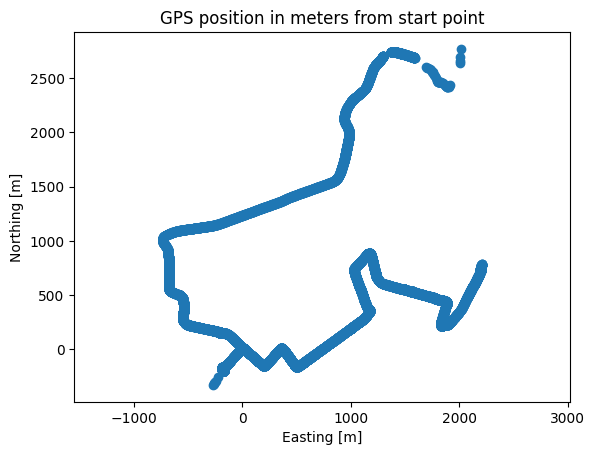

In [20]:
xy_locations = [gps_to_meters(start_location, df_gps['latitude'].iloc[i], df_gps['longitude'].iloc[i], df_gps['altitude'].iloc[i]) for i in range(len(df_gps))]

xy_locations = np.array(xy_locations).T

plt.scatter(xy_locations[0], xy_locations[1])
plt.title('GPS position in meters from start point')
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.axis('equal')
plt.show()

In [21]:
# taken from: https://mika-s.github.io/python/control-theory/kinematics/2017/12/18/transformation-to-pipi.html

from math import fabs, pi

def truncated_remainder(dividend, divisor):
    divided_number = dividend / divisor
    divided_number = \
        -int(-divided_number) if divided_number < 0 else int(divided_number)

    remainder = dividend - divisor * divided_number

    return remainder

def transform_to_pipi(input_angle):
    revolutions = int((input_angle + np.sign(input_angle) * pi) / (2 * pi))

    p1 = truncated_remainder(input_angle + np.sign(input_angle) * pi, 2 * pi)
    p2 = (np.sign(np.sign(input_angle)
                  + 2 * (np.sign(fabs((truncated_remainder(input_angle + pi, 2 * pi))
                                      / (2 * pi))) - 1))) * pi

    output_angle = p1 - p2

    return output_angle, revolutions

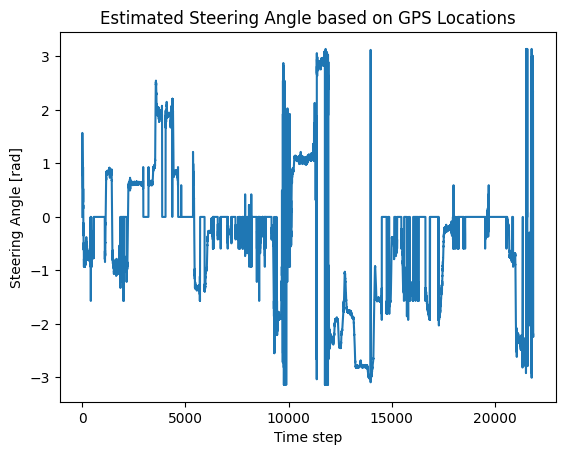

In [22]:
# visualizing angle between gps measurements
import math

prev_y = 0
prev_x = 0

angles_nonwrapped = []
angles_wrapped = []
distances = []

for location in xy_locations.T:
    dy = location[1] - prev_y
    dx = location[0] - prev_x
    distance = math.sqrt(dy**2 + dx**2)
    
    if distance < 0.025:
        angles_nonwrapped.append(0)
    else:
        angle = math.atan2(dy, dx)
        angles_nonwrapped.append(angle)

    distances.append(distance)


    prev_y = location[1]
    prev_x = location[0]

# wrapping makes no difference
plt.figure()
plt.plot(angles_nonwrapped)
plt.title('Estimated Steering Angle based on GPS Locations')
plt.xlabel('Time step')
plt.ylabel('Steering Angle [rad]')
plt.show()

616322 21871 30817 20


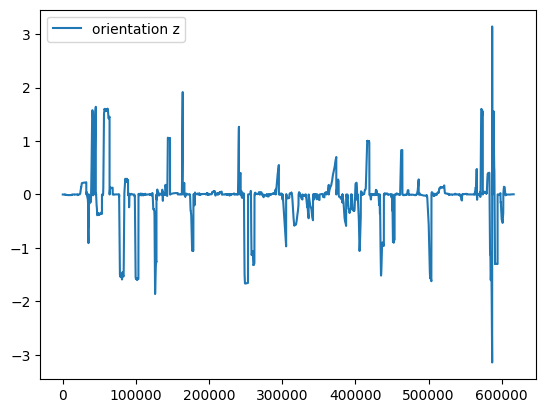

In [23]:
from math import ceil
z_angle = [angle[2] for angle in rot_euler]

gps_times = [i for i in range(0, len(z_angle), ceil(freq_ratio))]
print(len(z_angle), len(angles_nonwrapped), len(gps_times), ceil(freq_ratio))


plt.plot(z_angle, label='orientation z')
# plt.plot(angles_nonwrapped, label='gps orientation')
plt.legend()
plt.show()

1.4123305753228204
(3, 21871)


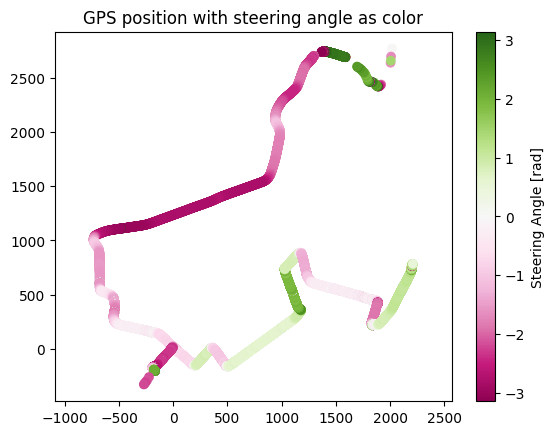

In [24]:
angles_nonwrapped = np.array(angles_nonwrapped)
angles_real = angles_nonwrapped[~(np.isnan(angles_nonwrapped))]

theta_var = angles_real.var()
print(theta_var)

%matplotlib inline
print(xy_locations.shape)
plt.scatter(x=xy_locations[0], y=xy_locations[1], c=angles_nonwrapped)
cmap = plt.get_cmap('PiYG')
plt.set_cmap(cmap)
plt.colorbar(label='Steering Angle [rad]')
plt.axis('equal')
plt.title('GPS position with steering angle as color')
plt.show()

In [108]:
# System Variables

# initial state

x = np.zeros(((8,1))) # x, y, theta, x_dot, y_dot, theta_dot, x_ddot, y_ddot

print(f'x {x.shape}:\n', x)
dt = 1/imu_freq # or get actual time difference

H = np.zeros((6,8))
H[0,0] = 1      # x
H[1,1] = 1      # y
H[2,2] = 1      # theta
H[3,5] = 1      # theta_dot
H[4,6] = 1      # x_ddot
H[5,7] = 1      # y_ddot

print(f'\nH {H.shape}:\n', H)

#               x    y theta x_dot y_dot theta_dot x_ddot y_ddot
F = np.array([[1.0, 0.0, 0.0, dt, 0.0, 0.0, 0.5*dt**2, 0.0],     # x
              [0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0, 0.5*dt**2],     # y
              [0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0],           # theta
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0],           # x_dot
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt],           # y_dot
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],          # theta_dot
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],          # x_ddot
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])         # y_ddot

print(f'\nA {F.shape}:\n', F)


# x = x + x_dot*dt + 0.5*x_ddot*dt^2
# y = y + y_dot*dt + 0.5*y_ddot*dt^2
# theta = theta + theta_dot*dt

# x_dot = x_dot + x_ddot*dt
# y_dot = y_dot + y_ddot*dt
# theta_dot = theta_dot

# x_ddot = x_ddot
# y_ddot = y_ddot

P = np.diag([10000, 10000, 10, 500, 500, 5, 50, 50]) # state covariance matrix

print(f'\nP {P.shape}:\n', P)


xy_cov = df_gps['position_covariance_0'].iloc[0]

# compute covariances of acceleration and angular velocity
imu_covariance = df_imu[['angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.x']].cov()

# display(imu_covariance)

imu_covariance = imu_covariance.to_numpy()

R = np.diag([xy_cov, xy_cov, theta_var]) # measurement noise
R = np.block([[R, np.zeros((3,3))], [np.zeros((3,3)), imu_covariance]])


print(f'\nR {R.shape}:\n', R)

x (8, 1):
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

H (6, 8):
 [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

A (8, 8):
 [[1.       0.       0.       0.004997 0.       0.       0.000012 0.      ]
 [0.       1.       0.       0.       0.004997 0.       0.       0.000012]
 [0.       0.       1.       0.       0.       0.004997 0.       0.      ]
 [0.       0.       0.       1.       0.       0.       0.004997 0.      ]
 [0.       0.       0.       0.       1.       0.       0.       0.004997]
 [0.       0.       0.       0.       0.       1.       0.       0.      ]
 [0.       0.       0.       0.       0.       0.       1.       0.      ]
 [0.       0.       0.       0.       0.       0.       0.       1.      ]]

P (8, 8):
 [[10000     0     0     0     0     0     0     0]
 [    0 10000     0     0     0     0     0     0]
 [    0     0    10     0     0     0 

In [78]:
# H for imu: we get theta_dot x_ddot, and y_ddot

H_imu = np.zeros((3,8))
H_imu[0,5] = 1
H_imu[1,6] = 1
H_imu[2,7] = 1
print(f'H_imu {H_imu.shape}:\n', H_imu)

# H for gps: we get x, y, and theta
H_gps = np.zeros((3,8))
H_gps[0,0] = 1
H_gps[1,1] = 1
H_gps[2,2] = 1
print(f'\nH_gps {H_gps.shape}:\n', H_gps)

R_imu = imu_covariance
print(f'\nR_imu {R_imu.shape}:\n', R_imu)

R_gps= np.diag([xy_cov, xy_cov, theta_var])
print(f'\nR_gps {R_gps.shape}:\n', R_gps)


H_imu (3, 8):
 [[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

H_gps (3, 8):
 [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]

R_imu (3, 3):
 [[ 0.00396  -0.000157 -0.000157]
 [-0.000157  0.621684  0.621684]
 [-0.000157  0.621684  0.621684]]

R_gps (3, 3):
 [[100.         0.         0.      ]
 [  0.       100.         0.      ]
 [  0.         0.         1.412331]]


In [79]:
# test
# x = np.array([1,2,3,4,5,6,7,8])
# print(x)
# print(F @ x, (F@x).shape)
# print()
# print(H_imu @ x, (H_imu @ x).shape)
# print()
# print(H_gps @ x, (H_gps @ x).shape)

In [80]:
import sympy
from sympy import (init_printing, Matrix, MatMul, 
                   integrate, symbols)

init_printing(use_latex='mathjax')
dt, phi = symbols('\Delta{t} \Phi_s')
F_k = Matrix([[1, dt, dt**2/2],
              [0,  1,      dt],
              [0,  0,       1]])


F = Matrix([[1.0, 0.0, 0.0, dt, 0.0, 0.0, 0.5*dt**2, 0.0],       # x
              [0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0, 0.5*dt**2],     # y
              [0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0],           # theta
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0],           # x_dot
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt],           # y_dot
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],          # theta_dot
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],          # x_ddot
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])         # y_ddot


Q_c = Matrix([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])*phi


Q_c = sympy.zeros(8,8)
Q_c[-1, -1] = 1
Q_c *= phi

Q = integrate(F * Q_c * F.T, (dt, 0, dt))

# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

⎡0               0                0  0         0          0  0               0
⎢                                                                             
⎢                       5                              4                      
⎢0        0.05⋅\Delta{t}          0  0  0.125⋅\Delta{t}   0  0  0.166666666666
⎢                                                                             
⎢0               0                0  0         0          0  0               0
⎢                                                                             
⎢0               0                0  0         0          0  0               0
⎢                                                                             
⎢                                                   3                         
⎢                        4                 \Delta{t}                          
⎢0        0.125⋅\Delta{t}         0  0     ──────────     0  0         0.5⋅\De
⎢                                              3    

In [81]:
# since dt is going to be very small, 0.1 at most, we can simplify Q

Q = np.matrix(np.zeros((8,8)))
process_noise = 2
Q[1,1] = 0.05*dt**5
Q[1,4] = 0.125*dt**4
Q[4,1] = 0.125*dt**4
Q[4,4] = (dt**3)/3
Q[1,7] = (dt**3)/6
Q[7,1] = (dt**3)/6
Q[4,7] = 0.5*dt**2
Q[7,4] = 0.5*dt**2
Q[7,7] = dt
Q*process_noise

# Q and F depend on dt, so we have to recompute them every time

TypeError: Cannot convert expression to float

In [82]:
# piecewise model

var = symbols('sigma^2_v')
v = Matrix([0, 0.5*dt**2, 0, 0, dt, 0, 0, 1])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
display(MatMul(Q, var))

Q = np.matrix(np.zeros((8,8)))
process_noise = 10**2
Q[1,1] = 0.25*dt**4
Q[1,4] = 0.5*dt**3
Q[4,1] = 0.5*dt**3
Q[4,4] = dt**2
Q[1,7] = 0.5*dt**2
Q[7,1] = 0.5*dt**2
Q[4,7] = dt
Q[7,4] = dt
Q[7,7] = dt
Q*process_noise

⎡0         0         0  0        0         0  0        0       ⎤    
⎢                                                              ⎥    
⎢                 4                     3                     2⎥    
⎢0  0.25⋅\Delta{t}   0  0  0.5⋅\Delta{t}   0  0  0.5⋅\Delta{t} ⎥    
⎢                                                              ⎥    
⎢0         0         0  0        0         0  0        0       ⎥    
⎢                                                              ⎥    
⎢0         0         0  0        0         0  0        0       ⎥    
⎢                                                              ⎥    
⎢                3                    2                        ⎥⋅σ²ᵥ
⎢0  0.5⋅\Delta{t}    0  0    \Delta{t}     0  0    \Delta{t}   ⎥    
⎢                                                              ⎥    
⎢0         0         0  0        0         0  0        0       ⎥    
⎢                                                              ⎥    
⎢0         0         0  0        0

TypeError: Cannot convert expression to float

In [83]:
print(df_imu['header.seq'][0], df_imu['header.seq'].iloc[-1])
print(df_imu['header.seq'].iloc[-1] - df_imu['header.seq'][0])


print(df_gps['header.seq'].iloc[0], df_gps['header.seq'].iloc[-1])
print(df_gps['header.seq'].iloc[-1] - df_gps['header.seq'].iloc[0])
print(len(df_imu['header.seq']), len(df_gps['header.seq']))


print()
print(df_imu['Time'][0], df_imu['Time'].iloc[-1])
print(df_imu['Time'].iloc[-1] - df_imu['Time'][0])


print(df_gps['Time'].iloc[0], df_gps['Time'].iloc[-1])
print(df_gps['Time'].iloc[-1] - df_gps['Time'].iloc[0])
print(len(df_imu['Time']), len(df_gps['Time']))





74256 690704
616448
3057 29787
26730
616322 21871

1697739278.741994 1697742361.0040452
3082.262051343918
1697739552.3366451 1697742231.7306333
2679.393988132477
616322 21871


<AxesSubplot: >

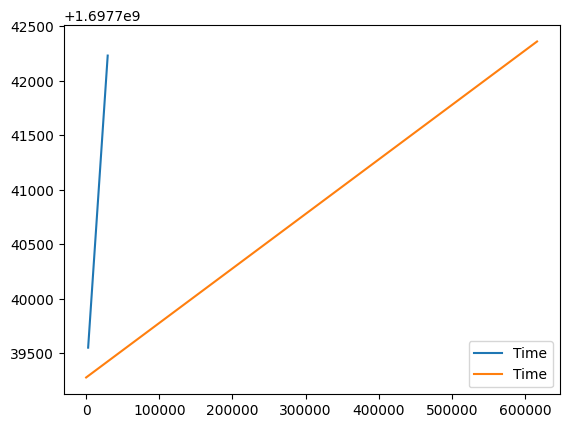

In [84]:
df_gps['Time'].plot(legend=True)
df_imu['Time'].plot(legend=True)
# plt.axis('equal')

In [127]:
from collections import deque

# create gps queue with needed data
q_gps = deque()
for i in range(len(df_gps)):

    data_dict = {}

    data_dict['time'] = df_gps['Time'].iloc[i]
    data_dict['lat'] = df_gps['latitude'].iloc[i]
    data_dict['lon'] = df_gps['longitude'].iloc[i]
    data_dict['alt'] = df_gps['altitude'].iloc[i]
    data_dict['cov'] = df_gps['position_covariance_0'].iloc[i]

    q_gps.append(data_dict)

# create imu queue with needed data
q_imu = deque()
for i in range(len(df_imu)):
    data_dict = {}

    data_dict['time'] = df_imu['Time'].iloc[i]
    data_dict['x_ddot'] = non_biased_accel_x.iloc[i]
    data_dict['y_ddot'] = non_biased_accel_y.iloc[i]
    data_dict['theta_dot'] = non_biased_gyro_z.iloc[i]

    q_imu.append(data_dict)

print(len(q_gps))
print(q_gps[0])

print(len(q_imu))
print(q_imu[0])

21871
{'time': 1697739552.3366451, 'lat': 42.341995833333335, 'lon': -71.084166, 'alt': -32.6, 'cov': 100.0}
616322
{'time': 1697739278.741994, 'x_ddot': 0.020146921509403337, 'y_ddot': -0.025899320041733072, 'theta_dot': -0.0006659837875326036}


In [128]:
def make_F(dt):
    F = np.array([[1.0, 0.0, 0.0, dt, 0.0, 0.0, 0.5*dt**2, 0.0], # x
        [0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0, 0.5*dt**2],           # y
        [0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0],                 # theta
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0],                 # x_dot
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt],                 # y_dot
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],                # theta_dot
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],                # x_ddot
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])               # y_ddot
    
    return F


def make_Q(dt):
    # simplified Q
    Q = np.matrix(np.zeros((8,8)))
    process_noise = 12**2
    Q[-1, -1] = dt*process_noise
    Q[-2, -2] = dt*process_noise

    # continuous white noise model
    # Q = np.matrix(np.zeros((8,8)))
    # process_noise = 5**2
    # Q[1,1] = 0.05*dt**5
    # Q[1,4] = 0.125*dt**4
    # Q[4,1] = 0.125*dt**4
    # Q[4,4] = (dt**3)/3
    # Q[1,7] = (dt**3)/6
    # Q[7,1] = (dt**3)/6
    # Q[4,7] = 0.5*dt**2
    # Q[7,4] = 0.5*dt**2
    # Q[7,7] = dt
    # Q*process_noise

    return Q


def make_R_gps(cov):
    R = np.diag([cov, cov, theta_var])
    return R


def get_gps_measurement(data_dict, prev_xy):
    x, y, _ = gps_to_meters(start_location, data_dict['lat'], data_dict['lon'], data_dict['alt'])

    angle = get_angle(prev_xy, (x,y))

    z = np.array([x, y, angle])

    return z.T


def get_angle(prev_xy, current_xy):
    dy = current_xy[1] - prev_xy[1]
    dx = current_xy[0] - prev_xy[0]
    distance = math.sqrt(dy**2 + dx**2)
    
    if distance < 0.025:
        return 0
    else:
        angle = math.atan2(dy, dx)
        return angle
    

def get_imu_measurement(data_dict):
    z = np.array([data_dict['theta_dot'], data_dict['x_ddot'], data_dict['y_ddot']])

    return z.T

In [129]:
last_t = 0
prev_xy = (0, 0)

I = np.eye(8)

poses = []

status = 0
while len(q_gps) > 0 and len(q_imu) > 0:
    # get appropriate measurement 
    # if there is gps measurement

    if q_gps[0]['time'] < q_imu[0]['time']:
        z_gps = q_gps.popleft()

        dt = z_gps['time'] - last_t
        last_t = z_gps['time']
        
        H = H_gps
        R = make_R_gps(z_gps['cov'])

        z = get_gps_measurement(z_gps, prev_xy)
        prev_xy = (z[0], z[1])
        
    else:
        z_imu = q_imu.popleft()
        dt = z_imu['time'] - last_t
        last_t = z_imu['time']

        H = H_imu
        R = R_imu

        z = get_imu_measurement(z_imu)

    F = make_F(dt)
    Q = make_Q(dt)


    # predict state
    x = F @ x

    # project error covariance
    P = (F @ P @ F.T) + Q

    # innovation
    y = (z - (H@x).T).T

    # kalman gain
    K = (P@H.T) @ np.linalg.inv((H@P@H.T) + R)

    # update state
    x += K@y

    # update estimate covariance
    P = (I - K@H) @ P

    pose = (x[0], x[1], x[2])
    poses.append(pose)

    if status % 50000 == 0:
        print(status, pose)

    status += 1



0 (array([-1.046515e+18]), array([-1.471492e+18]), array([-0.293567]))
50000 (array([-1.046515e+18]), array([-1.471492e+18]), array([-0.293567]))
100000 (array([482.257569]), array([-149.172941]), array([-0.280682]))
150000 (array([1093.051324]), array([808.839208]), array([-0.079109]))
200000 (array([1559.977879]), array([533.327687]), array([-0.097621]))
250000 (array([1884.70218]), array([427.686583]), array([-0.107917]))
300000 (array([1822.440805]), array([946.44858]), array([-0.060218]))
350000 (array([-1206.204217]), array([4097.399014]), array([-0.060218]))
400000 (array([1180.40563]), array([2963.870464]), array([-0.011992]))
450000 (array([-686.280648]), array([917.103597]), array([-0.230998]))
500000 (array([-536.234212]), array([403.983404]), array([-0.260964]))
550000 (array([-205.322386]), array([156.001557]), array([-0.269456]))
600000 (array([-117.480345]), array([-111.923607]), array([-0.28301]))


(612341, 3, 1)
(612340, 1)
(612340, 2, 1)
[[-1.046515e+18]
 [-1.471492e+18]]


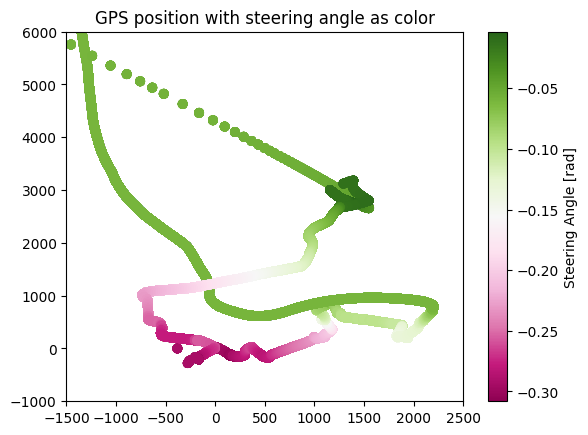

In [130]:
poses = np.array(poses)

test = poses
print(poses.shape)

colors = np.array([pose[2] for pose in test[0:-1]])
print(colors.shape)

xy_locations = np.array([[pose[0], pose[1]] for pose in test[0:-1]])
print(xy_locations.shape)
print(xy_locations[0])

%matplotlib inline

plt.scatter(x=xy_locations.T[0][0], y=xy_locations.T[0][1], c=colors)
cmap = plt.get_cmap('PiYG')
plt.set_cmap(cmap)
plt.colorbar(label='Steering Angle [rad]')
# plt.axis('equal')
plt.ylim(-1000, 6000)
plt.xlim(-1500, 2500)
plt.title('GPS position with steering angle as color')
plt.show()
